In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score

from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutations")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

In [3]:
results_auc_df_rt = pd.read_csv("./8_data/regression_transformer_results_auc_df.csv")
# results_auc_df_finetune = pd.read_csv("./6_data/results_auc_df_esm2_t12_35M_UR50D_glycosylase.csv")
# aggregate results_auc_df_fintune by the best auc
# results_auc_df_finetune = results_auc_df_finetune.groupby(["model_name", "rank_strategy"])["auc_score"].mean()
# results_auc_df_finetune = results_auc_df_finetune[results_auc_df_finetune["rank_strategy"] == "esm1v_5"]
# results_auc_df_finetune.iloc[results_auc_df_finetune["auc_score"].argmax(), :]
results_auc_df = pd.read_csv("./5_data/results_auc_df.csv")
results_auc_df_650M = results_auc_df[(results_auc_df["model_name"] == "esm2_t33_650M_UR50D") & (results_auc_df["rank_strategy"] == "esm1v_5")]
# results_auc_df_35M = results_auc_df[(results_auc_df["model_name"] == "esm2_t12_35M_UR50D") & (results_auc_df["rank_strategy"] == "esm1v_5")]
results_auc_df_concat = pd.concat([results_auc_df_650M, results_auc_df_rt])
# results_auc_df_concat = pd.concat([results_auc_df_650M, results_auc_df_35M, results_auc_df_finetune, results_auc_df_rt])


In [4]:
results_auc_df_concat[results_auc_df_concat["sequence_name"] == "2MKX.pdb"]

,sequence_name,model_name,rank_strategy,fpr,tpr,threshold,auc_score,wt_fitness,Unnamed: 0
77596,2MKX.pdb,esm2_t33_650M_UR50D,esm1v_5,[0. 0. 0. 0.00189394 0...,[0. 0.00280899 0.00561798 0.00561798 0...,[ 2.30365396 1.30365396 0.11621404 0. ...,0.890689,5.319625,NaN
529,2MKX.pdb,regression_transformer,esm1v_1,[0. 0.00568182 0.00757576 0.05871212 0...,[0. 0. 0.00280899 0.0252809 0...,[ 2.63 1.63 1.575 1.245 1.135 1.08...,0.552384,5.319625,529.0


In [5]:
plot_type = "denovo"
# plot_type = "natural"
results_auc_df_650M["auc_score"] = results_auc_df_650M["auc_score"].abs()
sequence_name_list = results_auc_df_650M.sort_values(by="auc_score", ascending=False)["sequence_name"].to_list()
denovo_sequence_name_list = [i for i in sequence_name_list if i.startswith("E") or i.startswith("G") or i.startswith("H") or i.startswith("r") or i.startswith("X")]
natural_sequence_name_list = [i for i in sequence_name_list if i not in denovo_sequence_name_list]
print(len(denovo_sequence_name_list), len(natural_sequence_name_list))

188 354


In [5]:
# save txt file for each protein
with open("./10_data/sequence_name_list.txt", "w") as f:
    f.write("\n".join(natural_sequence_name_list))

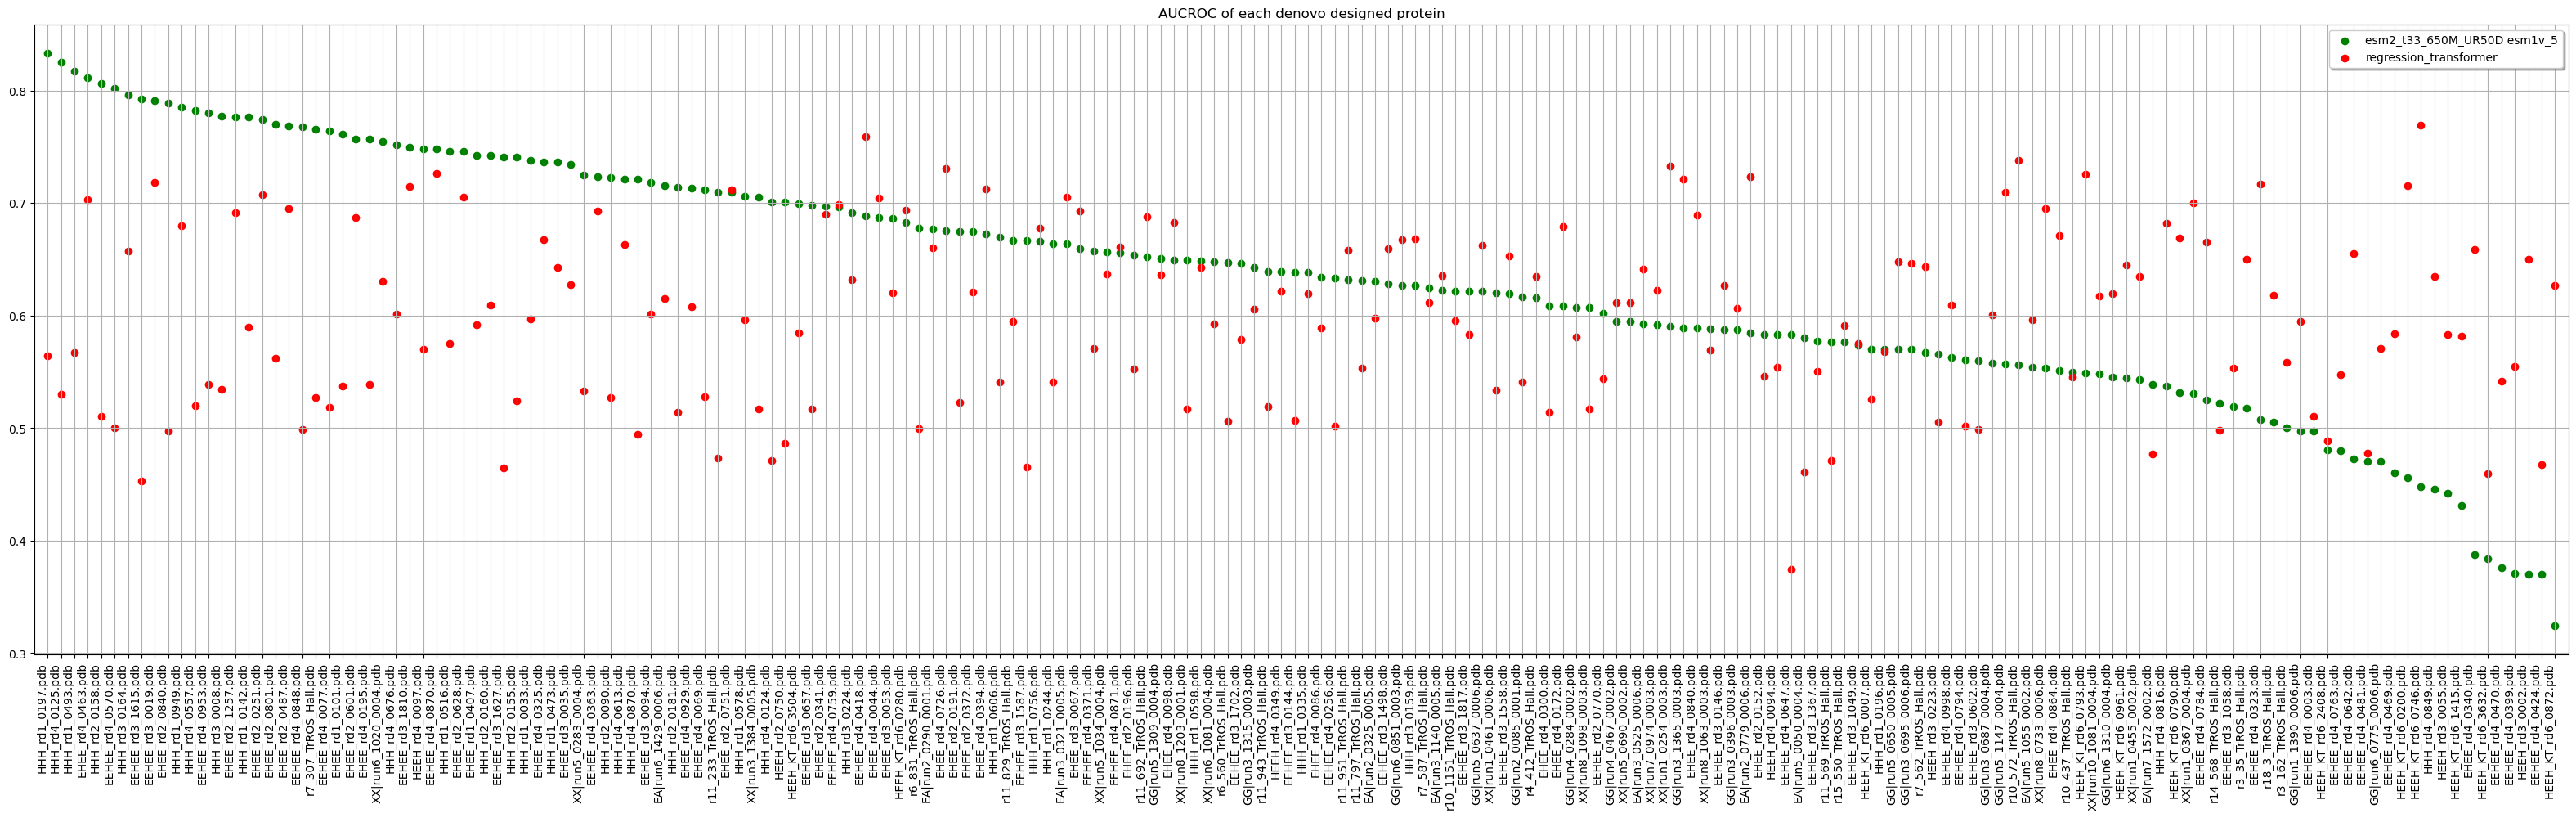

In [6]:

plot_num = 100
plt.figure(figsize=(40, 10))
if plot_type == "denovo":
    selected_sequence_name_list = denovo_sequence_name_list
elif plot_type == "natural":
    selected_sequence_name_list = natural_sequence_name_list
color_map = {
    "esm2_t33_650M_UR50D": "g",
    "esm2_t12_35M_UR50D": "b",
    "esm2_t12_35M_UR50D_glycosylase": "orange",
    "regression_transformer": "r"
}
for (model_name, rank_strategy), df in results_auc_df_concat.groupby(["model_name", "rank_strategy"]):
    # print(df.head())
    df = df[df["sequence_name"].isin(selected_sequence_name_list)]
    df = df.set_index("sequence_name").reindex(selected_sequence_name_list).reset_index()
    plt.scatter(df["sequence_name"], 
                df["auc_score"].abs(),
                color=color_map[model_name],
                label=f"{model_name} {rank_strategy}" if model_name != "regression_transformer" else f"{model_name}",
            )
plt.xticks(rotation=90, ha="right")
plt.xlim(-1, len(selected_sequence_name_list))
plt.grid()
plt.legend(loc='upper right', shadow=True)
if plot_type == "natural":
    plt.title("AUCROC of each natural protein")
    plt.savefig("./10_data/auc_plot_natural.png", dpi=300, bbox_inches='tight')
    plt.savefig("./10_data/auc_plot_natural.tiff", dpi=300, bbox_inches='tight')
elif plot_type == "denovo":
    plt.title("AUCROC of each denovo designed protein")
    plt.savefig("./10_data/auc_plot_denovo.png", dpi=300, bbox_inches='tight')
    plt.savefig("./10_data/auc_plot_denovo.tiff", dpi=300, bbox_inches='tight')


statistic: 0.332011059021517, pvalue: 1.6278463986096056e-12
statistic: 0.37489481908883276, pvalue: 6.571584299693181e-16


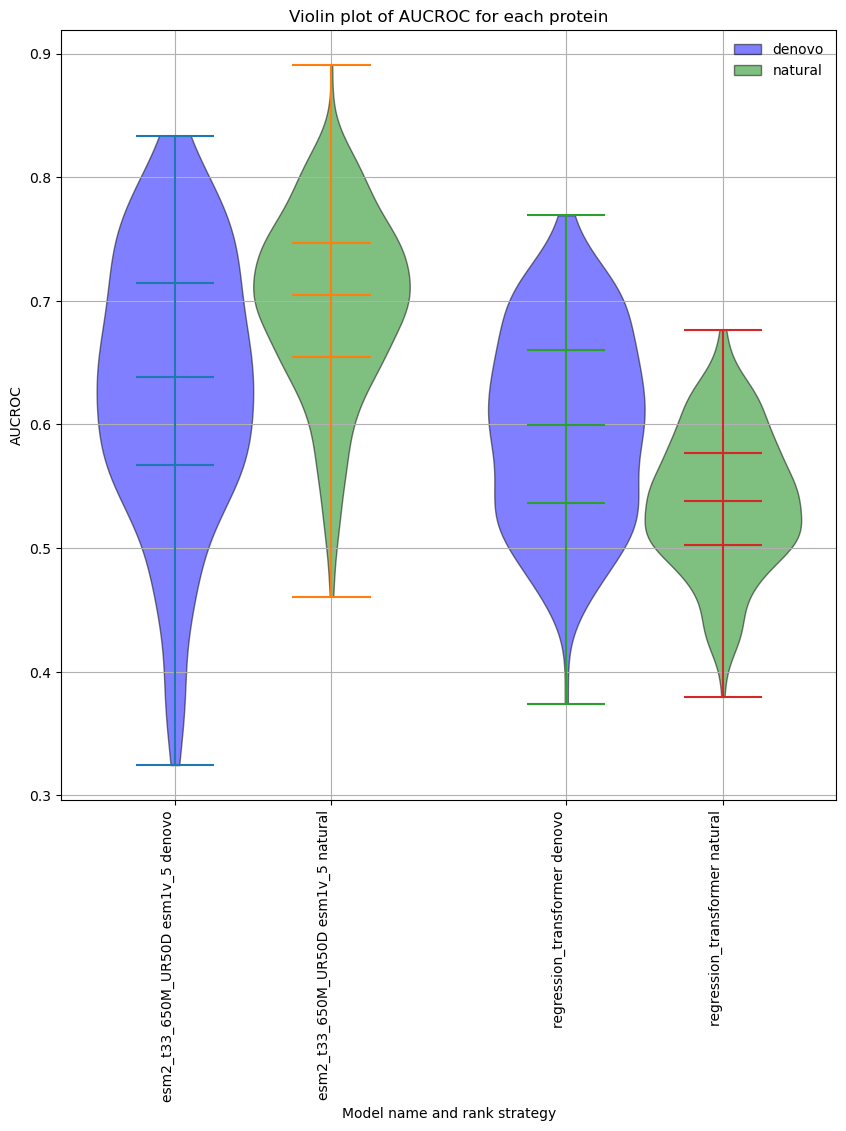

In [27]:
from scipy import stats
# 根据auc绘制箱型图
plt.figure(figsize=(10, 10))
selected_sequence_name_list = denovo_sequence_name_list
# selected_sequence_name_list = natural_sequence_name_list
idx = 0
xticks_map = {}
for (model_name, rank_strategy), df in results_auc_df_concat.groupby(["model_name", "rank_strategy"]):
    # print(df.head())
    denovo_df = df[df["sequence_name"].isin(denovo_sequence_name_list)]
    denovo_df = denovo_df.set_index("sequence_name").reindex(denovo_sequence_name_list).reset_index()
    denovo_df["auc_score"] = denovo_df["auc_score"].abs()
    natural_df = df[df["sequence_name"].isin(natural_sequence_name_list)]
    natural_df = natural_df.set_index("sequence_name").reindex(natural_sequence_name_list).reset_index()
    natural_df["auc_score"] = natural_df["auc_score"].abs()
    # df = df.iloc[:plot_num, :]
    # print(df.head())
    # print(df.shape)
    # break
    xticks_map[idx] = f"{model_name} {rank_strategy} denovo" if model_name != "regression_transformer" else f"{model_name} denovo"
    xticks_map[idx+0.2] = f"{model_name} {rank_strategy} natural" if model_name != "regression_transformer" else f"{model_name} natural"
    statistic, pvalue = stats.kstest(denovo_df["auc_score"], natural_df["auc_score"]) 
    print(f"statistic: {statistic}, pvalue: {pvalue}") 
    vp_denovo = plt.violinplot(denovo_df["auc_score"],
                    positions=[idx],
                    showextrema=True,
                    quantiles=[[0.25, 0.5, 0.75]],
                    widths=0.2,
            ) 
    for pc in vp_denovo['bodies']:  
        pc.set_facecolor('b')  
        pc.set_edgecolor('k')  
        pc.set_alpha(0.5)  
    vp_natural = plt.violinplot(natural_df["auc_score"],
                    positions=[idx+0.2],
                    showextrema=True,
                    quantiles=[[0.25, 0.5, 0.75]],
                    widths=0.2,
            )
    for pc in vp_natural['bodies']: 
        pc.set_facecolor('g')  
        pc.set_edgecolor('k')  
        pc.set_alpha(0.5)  
#     plt.text(idx+0.1, 0.8, f"p-value = {pvalue}", ha="center")  
    idx += 0.5
plt.legend(vp_denovo['bodies']+vp_natural['bodies'], ["denovo", "natural"], scatterpoints=1, loc='upper right', frameon=False)
plt.grid()
plt.xticks(list(xticks_map.keys()), list(xticks_map.values()), rotation=90, ha="right")
plt.xlabel("Model name and rank strategy")
plt.ylabel("AUCROC")
# plt.xlim(0, len(xticks_map))
plt.title("Violin plot of AUCROC for each protein")
plt.savefig("./10_data/violin_plot.png", dpi=600, bbox_inches='tight')
plt.savefig("./10_data/violin_plot.tiff", dpi=600, bbox_inches='tight')
plt.savefig("./10_data/violin_plot.pdf", dpi=600, bbox_inches='tight')